## Train from Scratch

Found 1678 images belonging to 4 classes.
Found 835 images belonging to 4 classes.
Epoch 1/30
100/100 [==============================] - 13s 133ms/step - loss: 0.9884 - acc: 0.5501 - val_loss: 0.5950 - val_acc: 0.6714
Epoch 2/30
100/100 [==============================] - 11s 114ms/step - loss: 0.5680 - acc: 0.7427 - val_loss: 0.2946 - val_acc: 0.7246
Epoch 3/30
100/100 [==============================] - 11s 113ms/step - loss: 0.4664 - acc: 0.7756 - val_loss: 0.2708 - val_acc: 0.7497
Epoch 4/30
100/100 [==============================] - 12s 119ms/step - loss: 0.3927 - acc: 0.8093 - val_loss: 0.6018 - val_acc: 0.7869
Epoch 5/30
100/100 [==============================] - 12s 117ms/step - loss: 0.3360 - acc: 0.8378 - val_loss: 0.3686 - val_acc: 0.8161
Epoch 6/30
100/100 [==============================] - 12s 121ms/step - loss: 0.2874 - acc: 0.8637 - val_loss: 1.0384 - val_acc: 0.7960
Epoch 7/30
100/100 [==============================] - 12s 122ms/step - loss: 0.2437 - acc: 0.8894 - val_los

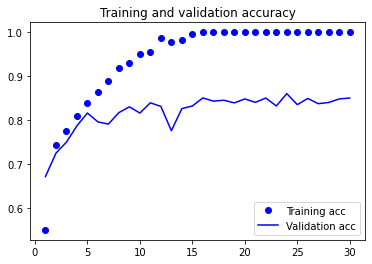

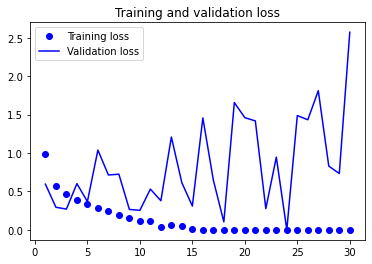

In [9]:
import os
from keras import layers
from keras import models
from keras import optimizers


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=0.001),
            metrics=['acc'])


    

from keras.preprocessing.image import ImageDataGenerator

base_dir = 'cat_dog_car_bike'
train_dir= os.path.join(base_dir, 'train')
validation_dir= os.path.join(base_dir, 'val')


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(32, 32),
        batch_size=20,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(32, 32),
        batch_size=20,
        class_mode='categorical')


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

#model.summary()


import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [13]:
# evaluate test set
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150), # very important: do not change this!
        batch_size=20,
        class_mode='categorical')

score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 200 images belonging to 4 classes.
Test loss: 0.08924185484647751
Test accuracy: 0.9750000238418579


## Transfer Learning from VGG16

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

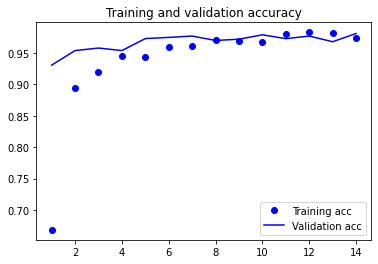

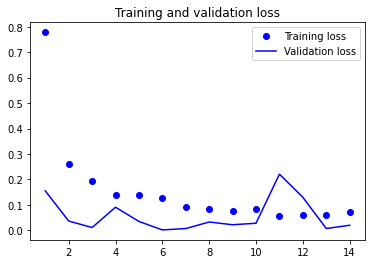

In [40]:
import os
from keras import layers
from keras import models
from keras import optimizers

from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(150, 150, 3))
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
conv_base.summary()

model = models.Sequential()
model.add(conv_base)
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(lr=0.00008),
            metrics=['acc'])

model.summary()

base_dir = 'cat_dog_car_bike'
train_dir= os.path.join(base_dir, 'train')
validation_dir= os.path.join(base_dir, 'val')
test_dir= os.path.join(base_dir, 'test')



from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=14,
      validation_data=validation_generator,
      validation_steps=50)




import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [44]:
# evaluate test set
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

score = model.evaluate(test_generator, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 200 images belonging to 4 classes.
Test loss: 0.0008203090401366353
Test accuracy: 0.9750000238418579
